In [24]:
from helpers.vae import VAE
from helpers.train import train_online, train

In [25]:
from helpers.convert_to_var_foo import convert_to_var

In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [28]:
states = np.load('trajectories/state_history.npy')
states_ids = np.load('trajectories/state_ids.npy')
counters = np.load('trajectories/counters.npy')
counters = counters.sum(axis=2)

In [29]:
def plot_corr_hist(corr):
    fontsize = 20
    plt.hist(corr, bins=20)
    plt.xlabel("Pearson's correlation coefficient", fontsize=fontsize)
    plt.ylabel("Number of episodes", fontsize=fontsize)
    plt.title("Correlation between E-counters and empirical counters", fontsize=fontsize)
    plt.grid()
    plt.show()

In [30]:
counters.shape

(7600, 10)

In [31]:
dim = counters.shape[1]
test = []
cur_class = 0
for cl, obj in zip(states_ids, states):
    if cl == cur_class:
        test.append(obj)
        cur_class += 1
    if cur_class == 10:
        break
test = np.array(test)

In [32]:
test.shape

(10, 10)

In [33]:
dim = 10
model = VAE(input_shape=(-1, dim), n_samples=25, fc_size=512)
optimizer = optim.RMSprop(model.parameters(), lr=5*1e-5, momentum=0.9, eps=1e-4)

In [34]:
optimizer.state_dict()['param_groups']

[{'alpha': 0.99,
  'centered': False,
  'eps': 0.0001,
  'lr': 5e-05,
  'momentum': 0.9,
  'params': [139661128611464,
   139661128610104,
   139661128660136,
   139661128661656,
   139661128660536,
   139661128659496,
   139661128632024,
   139661128633704,
   139661128632344,
   139661128630504,
   139661128570344,
   139661128570984,
   139661128571304,
   139661128568984],
  'weight_decay': 0}]

t= 0
0
t= 1
2
t= 2
4
t= 3
5
t= 4
7
t= 5
9
t= 6
11
t= 7
13
t= 8
14
t= 9
16


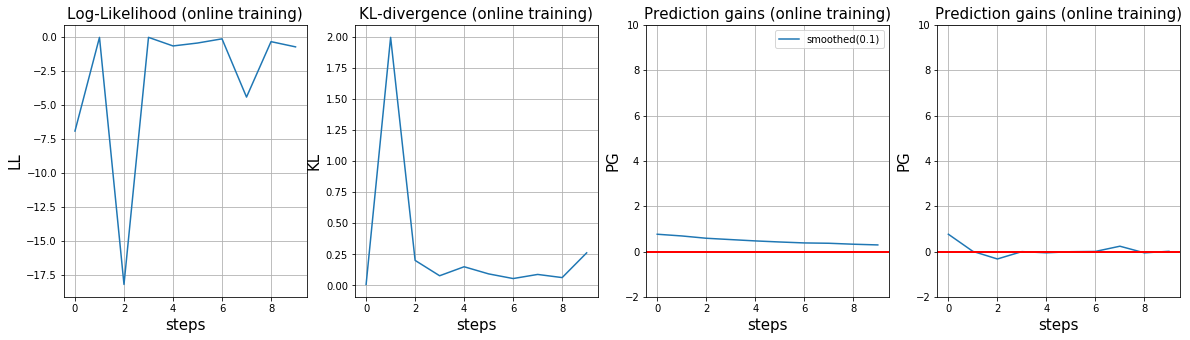

In [35]:
results = train_online(states_ids[:10], test, model, optimizer, kl_weight=1, img_name=None)

In [36]:
mean_last_ll, pct, all_log_probs, pgs, total_loss_gains, kl_gains = results

In [37]:
len(pgs[0])

17

In [15]:
def get_pseudo_count(pg):
    eps = 1e-6

    exp = np.exp(max(0, pg))
    cnt = (exp - 1 + eps) ** (- 1)

    return cnt

def get_counters(schedule, pgs, num_classes):
    real_counters = [[0] for _ in range(num_classes)]
    pseudo_counters = [[0] for _ in range(num_classes)]

    for j in range(num_classes):
        for i in range(len(pgs[j])):
            pseudo_counters[j].append(get_pseudo_count(pgs[j][i]))
            real_counters[j].append(real_counters[j][-1]+1)
            
    return real_counters, pseudo_counters

In [16]:
real_counters, pseudo_counters = get_counters(states_ids, pgs, 10)

In [17]:
len(real_counters)

10

In [18]:
len(pseudo_counters)

10

In [19]:
np.unique(states_ids, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 663,  566,  508,  457,  432,  408,  412,  407,  422, 3325]))

In [20]:
for i in range(10):
    print(len(real_counters[i]), len(pseudo_counters[i]))

18 18
14 14
11 11
11 11
11 11
11 11
11 11
11 11
11 11
11 11


In [21]:
corr_coef = []
for i, j in zip(real_counters, pseudo_counters):
    print
    corr_coef.append(np.corrcoef(i,j)[0][1])
corr_coef = np.array(corr_coef)

In [22]:
np.unique(corr_coef)

array([-4.61879383e-01, -2.88672291e-01, -1.44083695e-01,  2.71690610e-06,
        1.15470334e-01,  1.73213764e-01,  2.46278969e-01,  3.46410486e-01,
        4.04145760e-01,  5.37851470e-01])

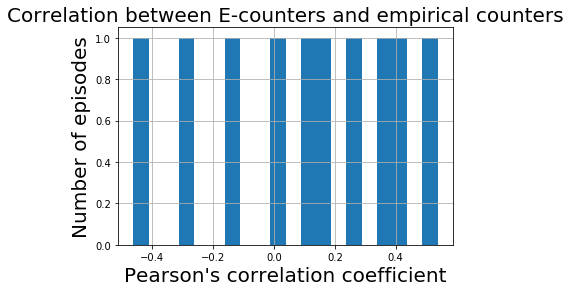

In [23]:
plot_corr_hist(corr_coef)